# SW중심대학 공동 AI 경진대회 <본선>

## 설명

1. 평가 산식

> - Accuracy (정확도)

2. 본선 평가

![](https://dacon.s3.ap-northeast-2.amazonaws.com/competition/235970/editor-image/166138683752218.jpeg)

3. 개인 또는 팀 참여 규칙

> - 본선 진출자는 예선과 동일한 팀원 및 팀명으로 참가해야 함
> - 본선 진출자 전원은 9/16(금)까지 재학증명서 또는 휴학증명서를 dacon@dacon.io 메일로 제출하야 함 [링크]
> ※ 허위 참가사실이 확인되거나 혹은 기간내 서류 제출을 하지 않을 시, 소속 팀 전체가 대회 탈락 처리됨을 유의 부탁드립니다.
> ※ 또한, 대회 기간 도중 팀원 중 졸업생 신분의 참가자가 포함되어있는 것이 확인될 경우에도 해당 팀 전체가 대회 탈락 처리됩니다.

 

4. 외부 데이터 및 사전 학습 모델 사용

> - 비상업적 용도로 사용할 수 있는 외부 데이터 사용 가능
> - 사용에 문제가 없는 사전 학습 모델(Pre-trained Model) 사용 가능


5. 유의 사항

> - 1일 최대 제출 횟수: 3회
> - 사용 가능 언어: Python, R
> - 모델 학습에서 평가 데이터셋(Test Dataset) 활용(Data Leakage) 시 실격 처리 됨 (참조 : 링크)
> - 답안을 수기로 작성하는 경우 실격 처리 됨
> - 다른 팀과의 아이디어 또는 코드 쉐어링이 의심되는 경우 데이콘에서 코드를 요청할 수 있으며, 기간 내 코드를 제출하지 않거나 치팅이 확인되는 경우 실격 처리 됨
> - 재학/휴학 증명서, 발표 자료 및 코드를 요청한 일자에 제출하지 않은 경우 실격 처리 됨
> - 최종 순위는 선택된 파일 중에서 채점되므로 참가자는 제출 창에서 자신이 최종적으로 채점을 받고 싶은 파일을 선택해야 함
> - 소프트웨어중심대학 공동 AI 경진대회 추진위원회는 대회 참가팀의 부정 행위를 금지하고 있으며, 이와 관련하여 본 경기를 위탁 운영하는 데이콘의 다른 경진대회에서 부정 제출 이력이 있는 경우에는 평가가 제한됩니다.
> - 자세한 사항은 아래의 링크를 참고해 주시기 바랍니다. https://dacon.io/notice/notice/13

6. 토론(질문)

> - 대회 운영 및 데이터 이상에 관련된 질문 외에는 답변을 드리지 않습니다.
> - 기타 질문은 토론 페이지를 통해 자유롭게 토론해주시기 바랍니다.
> - 소프트웨어중심대학 공동 AI 경진대회 추진위원회의 답변을 희망하시는 경우에는 토크 게시판의 대회 문의 게시글에 댓글을 달아주시면 검토하여 답변을 드리겠습니다.


## 모듈 및 설정

### 모듈

In [1]:
import os
import re
import cv2
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from jamo import h2j, j2hcj
from join_jamos import join_jamos
from sklearn.model_selection import train_test_split
from trdg.generators import GeneratorFromStrings, GeneratorFromDict
from deep_text_recognition_benchmark.create_lmdb_dataset import createDataset

Missing modules for handwritten text generation.


### 함수

In [3]:
def save_gt(filename, img_path_list, text_list, original=False, negative_img_path_list=None):
    if negative_img_path_list is not None:
        img_path_list = img_path_list + list(negative_img_path_list)
        text_list = text_list + ['.' for _ in range(len(negative_img_path_list))]
    with open(filename, 'w', encoding='utf-8') as f:
        for img_path, text in zip(img_path_list, text_list):
            if original:
                f.write(f'{img_path}\t{text}\n')
            else:
                f.write(f'{img_path}\t{j2hcj(h2j(text))}\n')

In [4]:
def data_generate(char, fonts_list, orientation=0):
    words = np.random.choice([1, 2, 3])
    fonts = [np.random.choice(fonts_list)]
    size = int(np.random.normal(300, 50))
    blur = np.random.choice([True, False])
    background_type = np.random.choice([0])
    distorsion_type = np.random.choice([0, 1, 2, 3])
    distorsion_orientation = np.random.choice([0, 1, 2])
    text_color = f'#{np.random.randint(0, 256):02X}{np.random.randint(0, 256):02X}{np.random.randint(0, 256):02X}'
    character_spacing = np.random.randint(0, 100)
    skewing_angle = np.random.randint(0, 10)
    margins = (
        size * np.random.randint(-5, 15) // 100,
        size * np.random.randint(-5, 15) // 100,
        size * np.random.randint(-5, 15) // 100,
        size * np.random.randint(-5, 15) // 100
    )
    stroke_width = np.random.choice([0, 0, 0, 3, 6])
    stroke_fill = f'#{np.random.randint(0, 256):02X}{np.random.randint(0, 256):02X}{np.random.randint(0, 256):02X}'

    if char is not None:
        length = np.random.randint(1, 8 // words)
        strings = ' '.join([''.join(list(np.random.choice(char, length))) for _ in range(words)])
        generator = GeneratorFromStrings(
            strings,
            fonts=fonts,
            language='ko',
            size=size,
            skewing_angle=skewing_angle,
            random_skew=True,
            blur=blur,
            background_type=background_type,
            distorsion_type=distorsion_type,
            distorsion_orientation=distorsion_orientation,
            text_color=text_color,
            orientation=orientation,
            character_spacing=character_spacing,
            margins=margins,
            stroke_width=stroke_width,
            stroke_fill=stroke_fill,
        )
    else:
        generator = GeneratorFromDict(
            fonts=fonts,
            language='ko',
            size=size,
            skewing_angle=skewing_angle,
            random_skew=True,
            blur=blur,
            # background_type=background_type,
            # distorsion_type=distorsion_type,
            # distorsion_orientation=distorsion_orientation,
            text_color=text_color,
            orientation=orientation,
            character_spacing=character_spacing,
            margins=margins,
            stroke_width=stroke_width,
            stroke_fill=stroke_fill,
        )

    for img, lbl in generator:
        return np.array(img), lbl

In [5]:
def img_padding(img, height, width, return_resize_shape=False):
    img_height, img_width = img.shape[:2]
    if img.shape[0] > height:
        resized_width = int(img.shape[1] * height / img.shape[0])
        img = cv2.resize(img, (resized_width, height))
        img_width = resized_width
        img_height = height
    if img.shape[1] > width:
        resized_height = int(img.shape[0] * width / img.shape[1])
        img = cv2.resize(img, (width, resized_height))
        img_width = width
        img_height = resized_height
    tmp = np.zeros((height, width, 3), dtype=np.uint8)
    tmp[0:img.shape[0], 0:img.shape[1]] = img
    tmp[img.shape[0]:, 0:img.shape[1]] = img[-1]
    tmp = np.transpose(tmp, (1, 0, 2))
    tmp[img.shape[1]:, 0:img.shape[0]] = img[:, -1]
    tmp = np.transpose(tmp, (1, 0, 2))
    tmp[img.shape[0]:, img.shape[1]:] = img[-1, -1]
    if return_resize_shape:
        return tmp, (img_height, img_width)
    else:
        return tmp

### 폴더 및 파일명

In [6]:
inputs = 'inputs'
outputs = 'outputs'
processing = 'processing'
history = 'history'

train_csv = 'train.csv'
test_csv = 'test.csv'
submission_csv = 'sample_submission.csv'

separation = 'separation'
generate_jamo = 'generate_jamo'
generate_freq = 'generate_freq'
generate_dict = 'generate_dict'
lmdb = 'lmdb'
craft = 'CRAFT/data_root_dir'

horizontal = 'horizontal'
vertical = 'vertical'

craft_train = 'ch4_training_images'
craft_test = 'ch4_test_images'
craft_train_gt = 'ch4_training_localization_transcription_gt'
craft_test_gt = 'ch4_test_localization_transcription_gt'

train_gt = 'train_gt.txt'
neg_train_gt = 'neg_train_gt.txt'
test_gt = 'test_gt.txt'
valid_gt = 'valid_gt.txt'
valid_no_space_gt = 'valid_no_space_gt.txt'
training_gt = 'training_gt.txt'
neg_training_gt = 'neg_training_gt.txt'
validation_gt = 'validation_gt.txt'
generate_gt = 'generate_gt.txt'

## 데이터

### CSV 파일 가져오기

In [7]:
train = pd.read_csv(os.path.join(inputs, train_csv))
test = pd.read_csv(os.path.join(inputs, test_csv))
submission = pd.read_csv(os.path.join(outputs, submission_csv))

### 새로운 텍스트 생성

In [27]:
first = [*'ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎ']
middle = [*'ㅏㅐㅑㅒㅓㅔㅕㅖㅗㅘㅙㅚㅛㅜㅝㅞㅟㅠㅡㅢㅣ']
last = [''] + [*'ㄱㄲㄳㄴㄵㄶㄷㄹㄺㄻㄼㄽㄾㄿㅀㅁㅂㅄㅅㅆㅇㅈㅊㅋㅌㅍㅎ']

jamo_ko = [join_jamos(f'{f}{m}{l}') for f in first for m in middle for l in last] + [' ']
freq_ko = [*'가각간갇갈감갑값갓강갖같갚갛개객걀걔거걱건걷걸검겁것겉게겨격겪견결겹경곁계고곡곤곧골곰곱곳공과관광괜괴굉교구국군굳굴굵굶굽궁권귀귓규균귤그극근글긁금급긋긍기긴길김깅깊까깍깎깐깔깜깝깡깥깨꺼꺾껌껍껏껑께껴꼬꼭꼴꼼꼽꽂꽃꽉꽤꾸꾼꿀꿈뀌끄끈끊끌끓끔끗끝끼낌나낙낚난날낡남납낫낭낮낯낱낳내냄냇냉냐냥너넉넌널넓넘넣네넥넷녀녁년념녕노녹논놀놈농높놓놔뇌뇨누눈눕뉘뉴늄느늑는늘늙능늦늬니닐님다닥닦단닫달닭닮담답닷당닿대댁댐댓더덕던덜덟덤덥덧덩덮데델도독돈돌돕돗동돼되된두둑둘둠둡둥뒤뒷드득든듣들듬듭듯등디딩딪따딱딴딸땀땅때땜떠떡떤떨떻떼또똑뚜뚫뚱뛰뜨뜩뜯뜰뜻띄라락란람랍랑랗래랜램랫략량러럭런럴럼럽럿렁렇레렉렌려력련렬렵령례로록론롬롭롯료루룩룹룻뤄류륙률륭르른름릇릎리릭린림립릿링마막만많말맑맘맙맛망맞맡맣매맥맨맵맺머먹먼멀멈멋멍멎메멘멩며면멸명몇모목몬몰몸몹못몽묘무묵묶문묻물뭄뭇뭐뭘뭣므미민믿밀밉밌및밑바박밖반받발밝밟밤밥방밭배백뱀뱃뱉버번벌범법벗베벤벨벼벽변별볍병볕보복볶본볼봄봇봉뵈뵙부북분불붉붐붓붕붙뷰브븐블비빌빔빗빚빛빠빡빨빵빼뺏뺨뻐뻔뻗뼈뼉뽑뿌뿐쁘쁨사삭산살삶삼삿상새색샌생샤서석섞선설섬섭섯성세섹센셈셋셔션소속손솔솜솟송솥쇄쇠쇼수숙순숟술숨숫숭숲쉬쉰쉽슈스슨슬슴습슷승시식신싣실싫심십싯싱싶싸싹싼쌀쌍쌓써썩썰썹쎄쏘쏟쑤쓰쓴쓸씀씌씨씩씬씹씻아악안앉않알앓암압앗앙앞애액앨야약얀얄얇양얕얗얘어억언얹얻얼엄업없엇엉엊엌엎에엔엘여역연열엷염엽엿영옆예옛오옥온올옮옳옷옹와완왕왜왠외왼요욕용우욱운울움웃웅워원월웨웬위윗유육율으윽은을음응의이익인일읽잃임입잇있잊잎자작잔잖잘잠잡잣장잦재쟁쟤저적전절젊점접젓정젖제젠젯져조족존졸좀좁종좋좌죄주죽준줄줌줍중쥐즈즉즌즐즘증지직진질짐집짓징짙짚짜짝짧째쨌쩌쩍쩐쩔쩜쪽쫓쭈쭉찌찍찢차착찬찮찰참찻창찾채책챔챙처척천철첩첫청체쳐초촉촌촛총촬최추축춘출춤춥춧충취츠측츰층치칙친칠침칫칭카칸칼캄캐캠커컨컬컴컵컷케켓켜코콘콜콤콩쾌쿄쿠퀴크큰클큼키킬타탁탄탈탑탓탕태택탤터턱턴털텅테텍텔템토톤톨톱통퇴투툴툼퉁튀튜트특튼튿틀틈티틱팀팅파팎판팔팝패팩팬퍼퍽페펜펴편펼평폐포폭폰표푸푹풀품풍퓨프플픔피픽필핏핑하학한할함합항해핵핸햄햇행향허헌험헤헬혀현혈협형혜호혹혼홀홈홉홍화확환활황회획횟횡효후훈훌훔훨휘휴흉흐흑흔흘흙흡흥흩희흰히힘']
fonts_list = list(map(lambda x : os.path.join('trdg/fonts/ko/', x), os.listdir('trdg/fonts/ko/')))

In [28]:
img_list, lbl_list = [], []
img_path_list, text_list = [], []

shutil.rmtree(os.path.join(processing, generate_dict, horizontal))
for idx in tqdm(range(1000)):
    img_path = f'./{generate_dict}/{idx:06d}.png'
    img, lbl = data_generate(None, fonts_list, orientation=1)
    while img.ndim == 0:
        img, lbl = data_generate(None, fonts_list, orientation=1)
    os.makedirs(os.path.dirname(os.path.join(processing, generate_dict, horizontal, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, generate_dict, horizontal, img_path), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    img_path_list.append(img_path)
    text_list.append(lbl)
    
save_gt(os.path.join(processing, generate_dict, horizontal, generate_gt), img_path_list, text_list)

100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s]


In [29]:
img_list, lbl_list = [], []
img_path_list, text_list = [], []

shutil.rmtree(os.path.join(processing, generate_dict, vertical))
for idx in tqdm(range(1000)):
    img_path = f'./{generate_dict}/{idx:06d}.png'
    img, lbl = data_generate(None, fonts_list, orientation=0)
    while img.ndim == 0:
        img, lbl = data_generate(None, fonts_list, orientation=0)
    os.makedirs(os.path.dirname(os.path.join(processing, generate_dict, vertical, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, generate_dict, vertical, img_path), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    img_path_list.append(img_path)
    text_list.append(lbl)
    
save_gt(os.path.join(processing, generate_dict, vertical, generate_gt), img_path_list, text_list)

100%|██████████| 1000/1000 [02:36<00:00,  6.38it/s]


In [30]:
img_list, lbl_list = [], []
img_path_list, text_list = [], []

shutil.rmtree(os.path.join(processing, generate_jamo, horizontal))
for idx in tqdm(range(1000)):
    img_path = f'./{generate_jamo}/{idx:06d}.png'
    img, lbl = data_generate(jamo_ko, fonts_list, orientation=1)
    while img.ndim == 0:
        img, lbl = data_generate(jamo_ko, fonts_list, orientation=1)
    os.makedirs(os.path.dirname(os.path.join(processing, generate_jamo, horizontal, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, generate_jamo, horizontal, img_path), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    img_path_list.append(img_path)
    text_list.append(lbl)
    
save_gt(os.path.join(processing, generate_jamo, horizontal, generate_gt), img_path_list, text_list)

100%|██████████| 1000/1000 [01:05<00:00, 15.21it/s]


In [31]:
img_list, lbl_list = [], []
img_path_list, text_list = [], []

shutil.rmtree(os.path.join(processing, generate_jamo, vertical))
for idx in tqdm(range(1000)):
    img_path = f'./{generate_jamo}/{idx:06d}.png'
    img, lbl = data_generate(jamo_ko, fonts_list, orientation=0)
    while img.ndim == 0:
        img, lbl = data_generate(jamo_ko, fonts_list, orientation=0)
    os.makedirs(os.path.dirname(os.path.join(processing, generate_jamo, vertical, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, generate_jamo, vertical, img_path), img)
    img_path_list.append(img_path)
    text_list.append(lbl)
    
save_gt(os.path.join(processing, generate_jamo, vertical, generate_gt), img_path_list, text_list)

100%|██████████| 1000/1000 [00:46<00:00, 21.46it/s]


In [32]:
img_list, lbl_list = [], []
img_path_list, text_list = [], []

shutil.rmtree(os.path.join(processing, generate_freq, horizontal))
for idx in tqdm(range(1000)):
    img_path = f'./{generate_freq}/{idx:06d}.png'
    img, lbl = data_generate(freq_ko, fonts_list, orientation=1)
    while img.ndim == 0:
        img, lbl = data_generate(freq_ko, fonts_list, orientation=1)
    os.makedirs(os.path.dirname(os.path.join(processing, generate_freq, horizontal, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, generate_freq, horizontal, img_path), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    img_path_list.append(img_path)
    text_list.append(lbl)
    
save_gt(os.path.join(processing, generate_freq, horizontal, generate_gt), img_path_list, text_list)

100%|██████████| 1000/1000 [00:50<00:00, 19.99it/s]


In [33]:
img_list, lbl_list = [], []
img_path_list, text_list = [], []

shutil.rmtree(os.path.join(processing, generate_freq, vertical))
for idx in tqdm(range(1000)):
    img_path = f'./{generate_freq}/{idx:06d}.png'
    img, lbl = data_generate(freq_ko, fonts_list, orientation=0)
    while img.ndim == 0:
        img, lbl = data_generate(freq_ko, fonts_list, orientation=0)
    os.makedirs(os.path.dirname(os.path.join(processing, generate_freq, vertical, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, generate_freq, vertical, img_path), img)
    img_path_list.append(img_path)
    text_list.append(lbl)
    
save_gt(os.path.join(processing, generate_freq, vertical, generate_gt), img_path_list, text_list)

100%|██████████| 1000/1000 [00:34<00:00, 28.97it/s]


### 모델 튜닝 및 최종 학습 데이터셋 생성

In [20]:
vertical_fixed = set([
    'train_00349.png', 'train_00351.png', 'train_00352.png', 'train_00480.png', 'train_00489.png',
    'train_02829.png', 'train_03289.png', 'train_03544.png', 'train_03545.png', 'train_04160.png', 
    'train_04240.png', 'train_04265.png', 'train_04352.png', 'train_04842.png', 'train_05205.png', 
    'train_05505.png', 'train_06115.png', 'train_06209.png', 'train_06218.png', 'train_06841.png', 
    'train_09293.png', 'train_10097.png', 'train_12088.png'
])
horizontal_fixed = set([
    'train_01218.png', 'train_01220.png', 'train_01549.png', 'train_01551.png', 'train_01637.png', 
    'train_05147.png', 'train_05442.png', 'train_06117.png'
])
remove = set([
    'train_00885.png', 'train_00887.png', 'train_01282.png', 'train_01637.png', 'train_01679.png', 
    'train_01681.png', 'train_02282.png', 'train_02372.png', 'train_04180.png', 'train_04320.png', 
    'train_04946.png', 'train_08290.png', 'train_08334.png', 'train_08358.png', 'train_08370.png', 
    'train_08371.png', 'train_08372.png', 'train_08393.png', 'train_08394.png', 'train_08396.png', 
    'train_08412.png', 'train_08448.png', 'train_08926.png', 'train_09938.png', 'train_10315.png', 
    'train_11220.png', 'train_11265.png', 'train_11301.png', 'train_11353.png', 'train_11448.png', 
    'train_11467.png', 'train_11478.png', 'train_11645.png', 'train_11681.png', 'train_11729.png', 
    'train_11761.png', 'train_11859.png', 'train_11870.png', 'train_11979.png', 'train_11992.png', 
    'train_12057.png'
])

In [ ]:
shutil.rmtree(os.path.join(processing, separation, horizontal))
shutil.rmtree(os.path.join(processing, separation, vertical))

for img_path, text in tqdm(list(zip(train['img_path'], train['text']))):
    img_name = os.path.basename(img_path)
    if img_name in remove:
        continue

    img = cv2.imread(os.path.join(inputs, img_path))
    os.makedirs(os.path.dirname(os.path.join(processing, separation, horizontal, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, separation, horizontal, img_path), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    os.makedirs(os.path.dirname(os.path.join(processing, separation, vertical, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, separation, vertical, img_path), img)

In [39]:
horizontal_img_path = []
horizontal_text = []
vertical_img_path = []
vertical_text = []

for img_path, text in tqdm(list(zip(train['img_path'], train['text']))):
    img_name = os.path.basename(img_path)
    if img_name in remove:
        continue

    if len(text) == 1:
        horizontal_img_path.append(img_path)
        horizontal_text.append(text)
        vertical_img_path.append(img_path)
        vertical_text.append(text)
    elif img_name in horizontal_fixed:
        horizontal_img_path.append(img_path)
        horizontal_text.append(text)
    elif img_name in vertical_fixed:
        vertical_img_path.append(img_path)
        vertical_text.append(text)
    else:
        img = cv2.imread(os.path.join(inputs, img_path))
        height, weight, color = img.shape
        if height > weight:
            horizontal_img_path.append(img_path)
            horizontal_text.append(text)
        else: 
            vertical_img_path.append(img_path)
            vertical_text.append(text)

# Horizontal
save_gt(os.path.join(processing, separation, horizontal, train_gt), horizontal_img_path, horizontal_text)
save_gt(os.path.join(processing, separation, horizontal, neg_train_gt), vertical_img_path, ['.'] * len(vertical_img_path))

X_train, X_valid, y_train, y_valid = train_test_split(horizontal_img_path, horizontal_text, test_size=0.1)
neg_X_train, neg_X_valid, neg_y_train, neg_y_valid = train_test_split(vertical_img_path, ['.'] * len(vertical_img_path), test_size=100)

save_gt(os.path.join(processing, separation, horizontal, training_gt), X_train, y_train)
save_gt(os.path.join(processing, separation, horizontal, neg_training_gt), neg_X_train, neg_y_train)
save_gt(os.path.join(processing, separation, horizontal, validation_gt), X_valid, y_valid, negative_img_path_list=neg_X_valid)

# Vertical
save_gt(os.path.join(processing, separation, vertical, train_gt), vertical_img_path, vertical_text)
save_gt(os.path.join(processing, separation, vertical, neg_train_gt), horizontal_img_path, ['.'] * len(horizontal_img_path))

X_train, X_valid, y_train, y_valid = train_test_split(vertical_img_path, vertical_text, test_size=0.1)
neg_X_train, neg_X_valid, neg_y_train, neg_y_valid = train_test_split(horizontal_img_path, ['.'] * len(horizontal_img_path), test_size=0.1)

save_gt(os.path.join(processing, separation, vertical, training_gt), X_train, y_train)
save_gt(os.path.join(processing, separation, vertical, neg_training_gt), neg_X_train, neg_y_train)
save_gt(os.path.join(processing, separation, vertical, validation_gt), X_valid, y_valid, negative_img_path_list=neg_X_valid)


100%|██████████| 12159/12159 [01:54<00:00, 106.36it/s]


### 최종 예측 데이터셋 생성

In [15]:
horizontal_img_path = []
vertical_img_path = []
horizontal_text = []
vertical_text = []
pattern = r'test_([0-9]{5}).png'
mapping = {
    '0':'ㄱ',    '1':'ㄴ',    '2':'ㄷ',    '3':'ㄹ',    '4':'ㅁ',
    '5':'ㅂ',    '6':'ㅅ',    '7':'ㅇ',    '8':'ㅈ',    '9':'ㅊ',
}

for img_path in tqdm(test['img_path']):
    img = cv2.imread(os.path.join(inputs, img_path))
    l = re.findall(pattern, img_path)
    idx = "".join(list(map(mapping.get, l[0])))
    height, weight, color = img.shape
    os.makedirs(os.path.dirname(os.path.join(processing, separation, horizontal, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, separation, horizontal, img_path), cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    horizontal_img_path.append(img_path)
    horizontal_text.append(idx)
    os.makedirs(os.path.dirname(os.path.join(processing, separation, vertical, img_path)), exist_ok = True)
    cv2.imwrite(os.path.join(processing, separation, vertical, img_path), img)
    vertical_img_path.append(img_path)
    vertical_text.append(idx)

# Horizontal
save_gt(os.path.join(processing, separation, horizontal, test_gt), horizontal_img_path, horizontal_text, original=True)

# Vertical
save_gt(os.path.join(processing, separation, vertical, test_gt), vertical_img_path, vertical_text, original=True)

100%|██████████| 3669/3669 [07:34<00:00,  8.08it/s]


### LMDB 데이터셋 생성

In [16]:
datasets_dict = [
    # { # Horizontal dataset generated by dict
    #     'tag': 'Horizontal dataset generated by dict',
    #     'inputPath': os.path.join(processing, generate_dict, horizontal),
    #     'gtFile': os.path.join(processing, generate_dict, horizontal, generate_gt),
    #     'outputPath': os.path.join(processing, lmdb, horizontal, generate_dict)
    # },
    # { # Vertical dataset generated by dict
    #     'tag': 'Vertical dataset generated by dict',
    #     'inputPath': os.path.join(processing, generate_dict, vertical),
    #     'gtFile': os.path.join(processing, generate_dict, vertical, generate_gt),
    #     'outputPath': os.path.join(processing, lmdb, vertical, generate_dict)
    # },
    # { # Horizontal dataset generated by jamo
    #     'tag': 'Horizontal dataset generated by jamo',
    #     'inputPath': os.path.join(processing, generate_jamo, horizontal),
    #     'gtFile': os.path.join(processing, generate_jamo, horizontal, generate_gt),
    #     'outputPath': os.path.join(processing, lmdb, horizontal, generate_jamo)
    # },
    # { # Vertical dataset generated by jamo
    #     'tag': 'Vertical dataset generated by jamo',
    #     'inputPath': os.path.join(processing, generate_jamo, vertical),
    #     'gtFile': os.path.join(processing, generate_jamo, vertical, generate_gt),
    #     'outputPath': os.path.join(processing, lmdb, vertical, generate_jamo)
    # },
    # { # Horizontal dataset generated by freq
    #     'tag': 'Horizontal dataset generated by freq',
    #     'inputPath': os.path.join(processing, generate_freq, horizontal),
    #     'gtFile': os.path.join(processing, generate_freq, horizontal, generate_gt),
    #     'outputPath': os.path.join(processing, lmdb, horizontal, generate_freq)
    # },
    # { # Vertical dataset generated by freq
    #     'tag': 'Vertical dataset generated by freq',
    #     'inputPath': os.path.join(processing, generate_freq, vertical),
    #     'gtFile': os.path.join(processing, generate_freq, vertical, generate_gt),
    #     'outputPath': os.path.join(processing, lmdb, vertical, generate_freq)
    # },
    { # Horizontal training dataset
        'tag': 'Horizontal training dataset',
        'inputPath': os.path.join(processing, separation, horizontal),
        'gtFile': os.path.join(processing, separation, horizontal, training_gt),
        'outputPath': os.path.join(processing, lmdb, horizontal, 'training')
    },
    { # Vertical training dataset
        'tag': 'Vertical training dataset',
        'inputPath': os.path.join(processing, separation, vertical),
        'gtFile': os.path.join(processing, separation, vertical, training_gt),
        'outputPath': os.path.join(processing, lmdb, vertical, 'training')
    },
    { # Horizontal validation dataset
        'tag': 'Horizontal validation dataset',
        'inputPath': os.path.join(processing, separation, horizontal),
        'gtFile': os.path.join(processing, separation, horizontal, validation_gt),
        'outputPath': os.path.join(processing, lmdb, horizontal, 'validation')
    },
    { # Vertical validation dataset
        'tag': 'Vertical validation dataset',
        'inputPath': os.path.join(processing, separation, vertical),
        'gtFile': os.path.join(processing, separation, vertical, validation_gt),
        'outputPath': os.path.join(processing, lmdb, vertical, 'validation')
    },
    { # Horizontal train dataset
        'tag': 'Horizontal train dataset',
        'inputPath': os.path.join(processing, separation, horizontal),
        'gtFile': os.path.join(processing, separation, horizontal, train_gt),
        'outputPath': os.path.join(processing, lmdb, horizontal, 'train')
    },
    { # Vertical train dataset
        'tag': 'Vertical train dataset',
        'inputPath': os.path.join(processing, separation, vertical),
        'gtFile': os.path.join(processing, separation, vertical, train_gt),
        'outputPath': os.path.join(processing, lmdb, vertical, 'train')
    },
    { # Horizontal test dataset
        'tag': 'Horizontal test dataset',
        'inputPath': os.path.join(processing, separation, horizontal),
        'gtFile': os.path.join(processing, separation, horizontal, test_gt),
        'outputPath': os.path.join(processing, lmdb, horizontal, 'test')
    },
    { # Vertical test dataset
        'tag': 'Vertical test dataset',
        'inputPath': os.path.join(processing, separation, vertical),
        'gtFile': os.path.join(processing, separation, vertical, test_gt),
        'outputPath': os.path.join(processing, lmdb, vertical, 'test')
    }
]

In [17]:
for dataset_dict in datasets_dict:
    print(dataset_dict['tag'])
    createDataset(
        inputPath = dataset_dict['inputPath'],
        gtFile = dataset_dict['gtFile'],
        outputPath = dataset_dict['outputPath']
    )

Horizontal training dataset
Written 1000 / 9694
Written 2000 / 9694
Written 3000 / 9694
Written 4000 / 9694
Written 5000 / 9694
Written 6000 / 9694
Written 7000 / 9694
Written 8000 / 9694
Written 9000 / 9694
Created dataset with 9694 samples
Vertical training dataset
Written 1000 / 9694
Written 2000 / 9694
Written 3000 / 9694
Written 4000 / 9694
Written 5000 / 9694
Written 6000 / 9694
Written 7000 / 9694
Written 8000 / 9694
Written 9000 / 9694
Created dataset with 9694 samples
Horizontal validation dataset
Written 1000 / 2424
Written 2000 / 2424
Created dataset with 2424 samples
Vertical validation dataset
Written 1000 / 2424
Written 2000 / 2424
Created dataset with 2424 samples
Horizontal train dataset
Written 1000 / 12118
Written 2000 / 12118
Written 3000 / 12118
Written 4000 / 12118
Written 5000 / 12118
Written 6000 / 12118
Written 7000 / 12118
Written 8000 / 12118
Written 9000 / 12118
Written 10000 / 12118
Written 11000 / 12118
Written 12000 / 12118
Created dataset with 12118 sampl

## 모델

### deep_text_recognition_benchmark

아래의 명령어를 실행해 수평 / 수직 방향에 대한 간판이미지를 따로 학습   
(메모리 누수 문제로 인해서 Jupyter notebook 안에서 실행하지 않음)

### CRAFT

* Put your training, test data in the following format   
    ```
    └── data_root_dir (you can change root dir in yaml file)
        ├── ch4_training_images
        │   ├── img_1.jpg
        │   └── img_2.jpg
        ├── ch4_training_localization_transcription_gt
        │   ├── gt_img_1.txt
        │   └── gt_img_2.txt
        ├── ch4_test_images
        │   ├── img_1.jpg
        │   └── img_2.jpg
        └── ch4_test_localization_transcription_gt
            ├── gt_img_1.txt
            └── gt_img_2.txt
    ```
* localization_transcription_gt files format :
    ```
    377,117,463,117,465,130,378,130,Genaxis Theatre
    493,115,519,115,519,131,493,131,[06]
    374,155,409,155,409,170,374,170,###
    ```

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train['img_path'], train['text'], test_size=0.2)

shutil.rmtree(os.path.join(craft))
os.makedirs(os.path.join(craft, craft_train), exist_ok=True)
os.makedirs(os.path.join(craft, craft_test), exist_ok=True)
os.makedirs(os.path.join(craft, craft_train_gt), exist_ok=True)
os.makedirs(os.path.join(craft, craft_test_gt), exist_ok=True)

for img_path, text in tqdm(list(zip(X_train, y_train))):
    img_name = os.path.basename(img_path)
    name = os.path.splitext(img_name)[0]
    img = cv2.imread(os.path.join(inputs, img_path))
    x, y, _ = img.shape
    # img, (x, y) = img_padding(img, 1000, 1000, return_resize_shape=True)
    cv2.imwrite(os.path.join(craft, craft_train, img_name.replace('png', 'jpg')), img)
    with open(os.path.join(craft, craft_train_gt, f'gt_{name}.txt'), 'w', encoding='utf-8') as f:
        f.write(f'0,0,{y},0,{y},{x},0,{x},{text}')
        # f.write(f'0,0,{x},0,{x},{y},0,{y},{text}')

for img_path, text in tqdm(list(zip(X_valid, y_valid))):
    img_name = os.path.basename(img_path)
    name = os.path.splitext(img_name)[0]
    img = cv2.imread(os.path.join(inputs, img_path))
    x, y, _ = img.shape
    # img, (x, y) = img_padding(img, 1000, 1000, return_resize_shape=True)
    cv2.imwrite(os.path.join(craft, craft_test, img_name.replace('png', 'jpg')), img)
    with open(os.path.join(craft, craft_test_gt, f'gt_{name}.txt'), 'w', encoding='utf-8') as f:
        f.write(f'0,0,{y},0,{y},{x},0,{x},{text}')
        # f.write(f'0,0,{x},0,{x},{y},0,{y},{text}')

100%|██████████| 2432/2432 [02:14<00:00, 18.10it/s]


In [19]:
for filename in tqdm(os.listdir('SynthText_kr/masks')):
    if filename.endswith('.txt'):
        name = filename.rstrip('_bb.txt')
        gt_filename = os.path.join('SynthText_kr/masks', f'{name}_bb.txt')
        img_filename = os.path.join('SynthText_kr/masks', f'{name}_with_text.png')

        shutil.copy2(img_filename, os.path.join(craft, craft_train, f'{name}.jpg'))
        shutil.copy2(gt_filename, os.path.join(craft, craft_train_gt, f'gt_{name}.txt'))
        

100%|██████████| 30780/30780 [03:38<00:00, 141.11it/s]


* Step 1 : To train CRAFT with SynthText dataset from scratch
    * Note : This step is not necessary if you use <a href="https://drive.google.com/file/d/1enVIsgNvBf3YiRsVkxodspOn55PIK-LJ/view?usp=sharing">this pretrain</a> as a checkpoint when start training step 2. You can download and put it in `exp/CRAFT_clr_amp_29500.pth` and change `ckpt_path` in the config file according to your local setup.
    ```
    CUDA_VISIBLE_DEVICES=0 python3 trainSynth.py --yaml=syn_train
    ```

* Step 2 : To train CRAFT with [SynthText + IC15] or custom dataset
    ```
    ## if you run on single GPU
    CUDA_VISIBLE_DEVICES=0 python3 train.py --yaml=custom_data_train
    
    ## if you run on multi GPU               
    CUDA_VISIBLE_DEVICES=0,1 python3 train_distributed.py --yaml=custom_data_train   
    ```

## 결과 확인

### deep_text_recognition_benchmark 학습 결과 추출

In [6]:
pattern0 = r'batch_size: ([0-9]{1,3})'
pattern1 = r'\[([0-9]{1,5})/([0-9]{1,5})\] Train loss: ([0-9]{1,3})\.([0-9]{1,5}), Valid loss: ([0-9]{1,3})\.([0-9]{1,5}), Elapsed_time: ([0-9]{1,7})\.([0-9]{1,5})'
pattern2 = r'Current_accuracy : ([0-9]{1,2})\.([0-9]{1,3}), Current_norm_ED  : ([0-9]{1,2})\.([0-9]{1,2})'
pattern3 = r'Best_accuracy    : ([0-9]{1,2})\.([0-9]{1,3}), Best_norm_ED     : ([0-9]{1,2})\.([0-9]{1,2})'

for folder in os.listdir('saved_models'):
    write = False
    batch_size = 0
    iterations = []
    interval_ft = [0]
    train_loss = []
    valid_loss = []
    elapsed_time = []
    current_accuracy = []
    current_norm_ed = []
    best_accuracy = []
    best_norm_ed = []

    filename = f'saved_models/{folder}/opt.txt'
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
    except:
        with open(filename, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    for line in lines:
        l = re.findall(pattern0, line)
        if len(l) > 0:
            batch_size = int(l[0])

    filename = f'saved_models/{folder}/log_train.txt'
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
    except:
        with open(filename, 'r', encoding='utf-8') as f:
            lines = f.readlines()

    for line in lines:
        l = re.findall(pattern1, line)
        if len(l) > 0:
            if l[0][0] == '1':
                write = False
            else:
                write = True
        if len(l) > 0 and write:
            iterations.append(int(l[0][0]))
            train_loss.append(float(l[0][2] + '.' + l[0][3]))
            valid_loss.append(float(l[0][4] + '.' + l[0][5]))
            elapsed_time.append(float(l[0][6] + '.' + l[0][7]))
            continue

        l = re.findall(pattern2, line)
        if len(l) > 0 and write:
            current_accuracy.append(float(l[0][0] + '.' + l[0][1]))
            current_norm_ed.append(float(l[0][2] + '.' + l[0][3]))
            continue

        l = re.findall(pattern3, line)
        if len(l) > 0 and write:
            best_accuracy.append(float(l[0][0] + '.' + l[0][1]))
            best_norm_ed.append(float(l[0][2] + '.' + l[0][3]))
            continue

    iterations_ft = 0
    pre_iterations = 0
    for idx, (i, acc) in enumerate(zip(iterations, current_accuracy)):
        if i == 100 and acc // 1 != 0:
            iterations_ft = iterations_ft + pre_iterations
        iterations[idx] = iterations[idx] + iterations_ft
        pre_iterations = i
    iterations = np.array(iterations) * batch_size

    df = pd.DataFrame(
        {
            'iterations': iterations,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'elapsed_time': elapsed_time,
            'current_accuracy': current_accuracy,
            'current_norm_ed': current_norm_ed,
            'best_accuracy': best_accuracy,
            'best_norm_ed': best_norm_ed
        }
    )
    os.makedirs(history, exist_ok=True)
    df.to_csv(f'{history}/{folder}.csv', index=False)

### deep_text_recognition_benchmark 학습 결과 확인

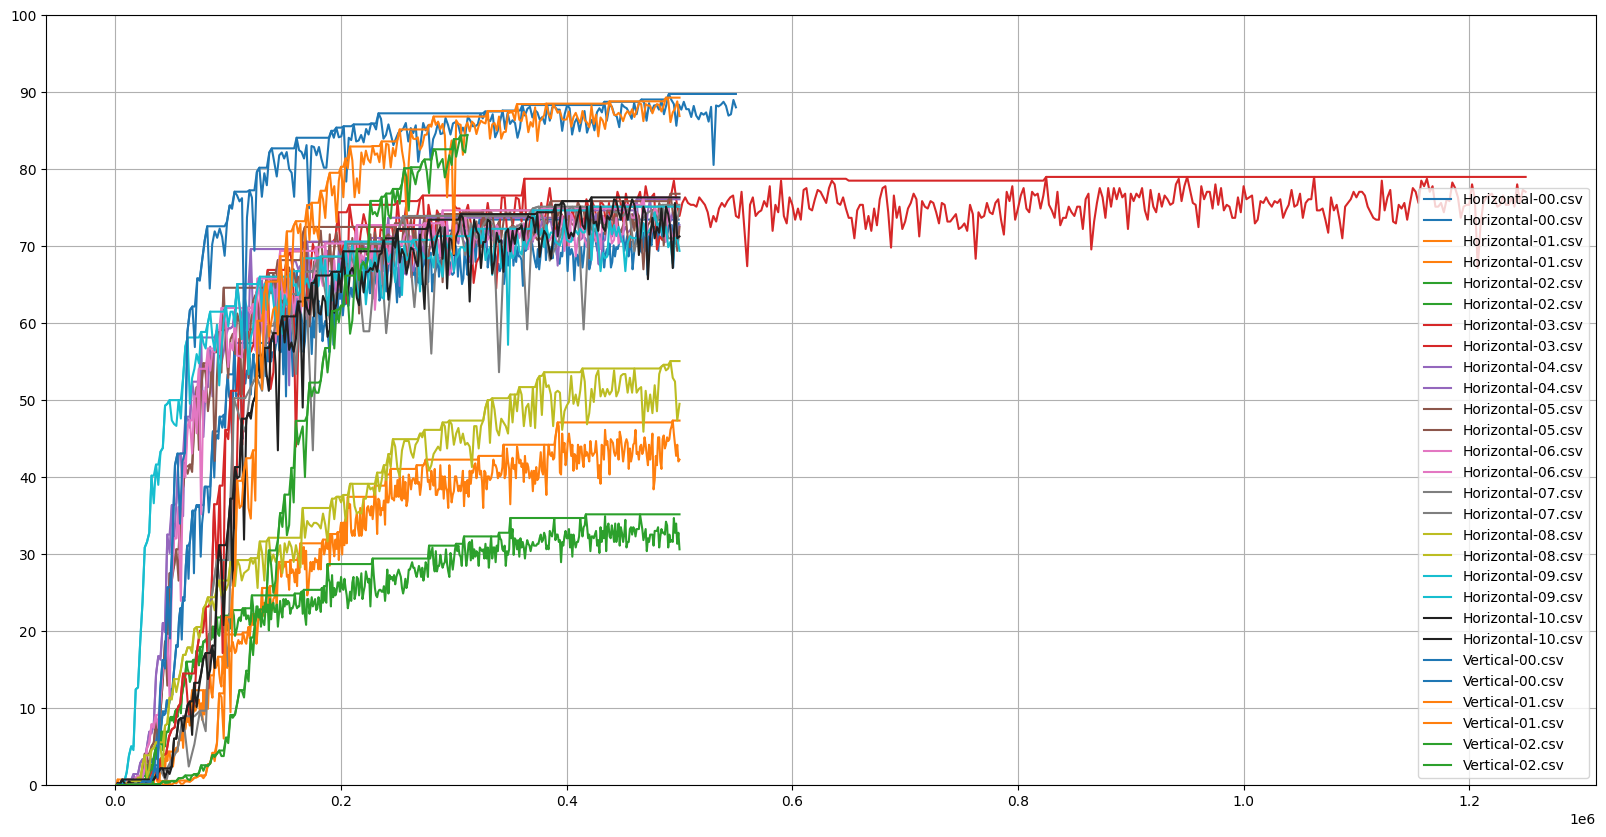

In [12]:
cmap = [
    (31, 119, 180, 255),
    (255, 127, 14, 255), 
    (44, 160, 44, 255), 
    (214, 39, 40, 255), 
    (148, 103, 189, 255), 
    (140, 86, 75, 255), 
    (227, 119, 194, 255), 
    (127, 127, 127, 255), 
    (188, 189, 34, 255),
    (23, 190, 207, 255),
    (32, 32, 32, 255)]

def cmap_to_float(cmap):
    return np.array(cmap, dtype=np.float32) / 255.0

cmap = cmap_to_float(cmap)

plt.figure(figsize=(20, 10))
for idx, file in enumerate(os.listdir(history)):
    df = pd.read_csv(f'{history}/{file}')
    plt.plot(
        df['iterations'], df['current_accuracy'], 
        label=f'{file}', c=cmap[idx % len(cmap)])
    plt.plot(
        list(df['iterations']), 
        list(df['best_accuracy']), 
        label=f'{file}', c=cmap[idx % len(cmap)])
plt.legend(loc='lower right')
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.grid()
plt.show()

### deep_text_recognition_benchmark 테스트

In [48]:
files = [
    'result/test/saved_models_Horizontal-03_best_accuracy.pth/log_evaluation.txt',
    'result/test/saved_models_Horizontal-12_best_accuracy.pth/log_evaluation.txt',
    'result/test/saved_models_Vertical-00_best_accuracy.pth/log_evaluation.txt',
    'result/test/saved_models_Vertical-04_best_accuracy.pth/log_evaluation.txt'
]
csv = {
    'not_horizontal': [], 'not_vertical': [],
    'pred_0': [], 'pred_1': [], 'pred_2': [], 'pred_3': []}

labels = []
for file_idx, file in enumerate(files):
    with open(file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        splitted = line.strip().split('\t')
        if len(splitted) == 3:
            confidence, label, pred = splitted
        else:
            confidence, label = splitted
            pred = ''
        if file_idx == 1:
            if pred == '.':
                csv['not_horizontal'].append('1.0')
            else:
                csv['not_horizontal'].append('0.0')
        if file_idx == 3:
            if pred == '.':
                csv['not_vertical'].append('1.0')
            else:
                csv['not_vertical'].append('0.0')
        csv[f'pred_{file_idx}'].append(confidence)

pd.DataFrame(csv).to_csv('outputs/test.csv', index=False)


In [10]:
vertical_fixed = set([
    'train_00349.png', 'train_00351.png', 'train_00352.png', 'train_00480.png', 'train_00489.png',
    'train_02829.png', 'train_03289.png', 'train_03544.png', 'train_03545.png', 'train_04160.png', 
    'train_04240.png', 'train_04265.png', 'train_04352.png', 'train_04842.png', 'train_05205.png', 
    'train_05505.png', 'train_06115.png', 'train_06209.png', 'train_06218.png', 'train_06841.png', 
    'train_09293.png', 'train_10097.png', 'train_12088.png'
])
horizontal_fixed = set([
    'train_01218.png', 'train_01220.png', 'train_01549.png', 'train_01551.png', 'train_01637.png', 
    'train_05147.png', 'train_05442.png', 'train_06117.png'
])
remove = set([
    'train_00885.png', 'train_00887.png', 'train_01282.png', 'train_01637.png', 'train_01679.png', 
    'train_01681.png', 'train_02282.png', 'train_02372.png', 'train_04180.png', 'train_04320.png', 
    'train_04946.png', 'train_08290.png', 'train_08334.png', 'train_08358.png', 'train_08370.png', 
    'train_08371.png', 'train_08372.png', 'train_08393.png', 'train_08394.png', 'train_08396.png', 
    'train_08412.png', 'train_08448.png', 'train_08926.png', 'train_09938.png', 'train_10315.png', 
    'train_11220.png', 'train_11265.png', 'train_11301.png', 'train_11353.png', 'train_11448.png', 
    'train_11467.png', 'train_11478.png', 'train_11645.png', 'train_11681.png', 'train_11729.png', 
    'train_11761.png', 'train_11859.png', 'train_11870.png', 'train_11979.png', 'train_11992.png', 
    'train_12057.png'
])

horizontal_img_path = []
horizontal_text = []
vertical_img_path = []
vertical_text = []

for img_path, text in tqdm(list(zip(train['img_path'], train['text']))):
    img_name = os.path.basename(img_path)
    if img_name in remove:
        continue

    if len(text) == 1:
        horizontal_img_path.append(img_path)
        horizontal_text.append(text)
        vertical_img_path.append(img_path)
        vertical_text.append(text)
    elif img_name in horizontal_fixed:
        horizontal_img_path.append(img_path)
        horizontal_text.append(text)
    elif img_name in vertical_fixed:
        vertical_img_path.append(img_path)
        vertical_text.append(text)
    else:
        img = cv2.imread(os.path.join(inputs, img_path))
        height, weight, color = img.shape
        if height > weight:
            horizontal_img_path.append(img_path)
            horizontal_text.append(text)
        else: 
            vertical_img_path.append(img_path)
            vertical_text.append(text)


100%|██████████| 12159/12159 [03:01<00:00, 67.14it/s] 


In [11]:
with open(os.path.join(processing, separation, horizontal, valid_gt), encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        img_path, text = line.strip().split('\t')
        if len(text) > 30:
            continue
        
        if img_path in horizontal_img_path:
            csv['horizontal'].append('1.0')
        else:
            csv['horizontal'].append('0.0')


In [22]:
labels = []
with open(files[3], 'r') as f:
    lines = f.readlines()

for line in lines:
    confidence, label, pred = line.strip().split('\t')
    labels.append(label)

In [35]:
csv['horizontal'] = []
not_text = 0
with open(os.path.join(processing, separation, horizontal, valid_gt), encoding='utf-8') as f:
    lines = f.readlines()
    for idx, line in enumerate(lines):
        img_path, text = line.strip().split('\t')
        
        if len(text) > 30:
            continue

        assert text == labels[idx], f'{text} != {labels[idx]}'

        if img_path in horizontal_img_path:
            csv['horizontal'].append('1.0')
        else:
            csv['horizontal'].append('0.0')


In [40]:
df = pd.DataFrame(csv)
df.to_csv('outputs/prediction.csv', index=False)

In [39]:
from pycaret.classification import *

ModuleNotFoundError: No module named 'pycaret'

In [12]:
files = [
    'result/saved_models_Horizontal-00_best_accuracy.pth/log_evaluation.txt',
    'result/saved_models_Horizontal-12_best_accuracy.pth/log_evaluation.txt',
    'result/saved_models_Vertical-00_best_accuracy.pth/log_evaluation.txt',
    'result/saved_models_Vertical-04_best_accuracy.pth/log_evaluation.txt'
]
mapping_reverse = {
    'ㄱ':'0', 'ㄴ':'1', 'ㄷ':'2', 'ㄹ':'3', 'ㅁ':'4',
    'ㅂ':'5', 'ㅅ':'6', 'ㅇ':'7', 'ㅈ':'8', 'ㅊ':'9'
}

preds = {}
confidences = {}
for file_idx, file in enumerate(files):
    with open(file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        confidence, idx, pred = line.strip().split('\t')
        idx = int(''.join(list(map(mapping_reverse.get, idx))))
        confidences.setdefault(idx, [0 for _ in range(len(files))])
        preds.setdefault(idx, ['' for _ in range(len(files))])
        confidences[idx][file_idx] = float(confidence)
        preds[idx][file_idx] = pred

for idx in preds:
    if preds[idx][1] == '.' and preds[idx][3] == '.':
        if confidences[idx][1] > confidences[idx][3]:
            preds[idx] = preds[idx][3]
        else   
            preds[idx] = preds[idx][]
    elif preds[idx][1] == '.' and preds[idx][3] != '.':
        if confidences[idx][2] > confidences[idx][3]:
            preds[idx] = preds[idx][2]
        else:
            preds[idx] = preds[idx][3]
    elif preds[idx][1] != '.' and preds[idx][3] == '.':
        if confidences[idx][0] > confidences[idx][1]:
            preds[idx] = preds[idx][0]
        else:
            preds[idx] = preds[idx][1]
    else:
        if confidences[idx][0] > confidences[idx][1] and confidences[idx][0] > confidences[idx][2] and confidences[idx][0] > confidences[idx][3]:
            preds[idx] = preds[idx][0]
        elif confidences[idx][1] > confidences[idx][0] and confidences[idx][1] > confidences[idx][2] and confidences[idx][1] > confidences[idx][3]:
            preds[idx] = preds[idx][1]
        elif confidences[idx][2] > confidences[idx][0] and confidences[idx][2] > confidences[idx][1] and confidences[idx][2] > confidences[idx][3]:
            preds[idx] = preds[idx][2]
        else:
            preds[idx] = preds[idx][3]


TypeError: sequence item 1: expected str instance, NoneType found

In [10]:
preds = list(zip(map(join_jamos, (preds.values())), preds.keys()))
preds.sort(key = lambda x: x[1])
submission['text'] = list(zip(*preds))[0]
submission.to_csv(os.path.join(outputs, 'submission.csv'), index=False)